# Test Statistic for Random Forest Independence Test
In this notebook, we will work on generating a test statistic using our random forest estimate of conditional entropy. Our test is setup as so:  

Given $(Y, X)$, where $Y$ is binary.  
$H_0$: $X$ is independent from $Y$  
$H_a$: $X$ is dependent on $Y$  

This can be translated to:  
$H_0$: $MI(X, Y) = 0$  
$H_a$: $MI(X, Y) \neq 0$  

There are two methods we explore in this notebook:
1. Permutation test
2. Compute the cdf of H(Y) evaluated at H(Y|X; under alternative)


## 1. Permutation test
Under the null, $X$ and $Y$ are independent. This means you should be able to permute around the Y labels and still get the same mutual information / coditional entropy. So, for the permtuation test, we will do exactly this:  

1. Permute the Y labels
2. Calculate Mutual information
3. Repeat 1000 times
4. How many times out of total trials did we get mutual information = 0?

We will focus on the same example as the previous notebooks.
Consider $(X, Y)$. Let $Y \sim Bernoulli(1/2)$ ($Y$ = -1 or 1) and $X \sim \mathcal N(y\mu, 1)$  

Note, we are focusing on one dimensional case for now.

### Sampling Code

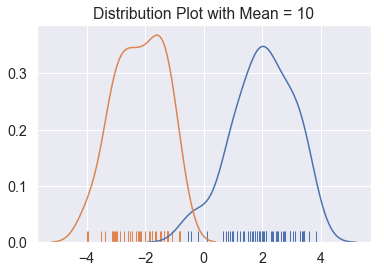

In [27]:
import numpy as np

# NOTE: we are storing y's as 1's or 0's but still doing the mean stuff correctly
def get_sample(n, mean, var):
    x_sample = []
    y_sample = []
    for i in range(n):
        y = np.random.binomial(1, .5)
        if (y == 0):
            x = np.random.normal(-mean, var)
        else:
            x = np.random.normal(mean, var)
        x_sample.append(x)
        y_sample.append(y)
    return x_sample, y_sample

import seaborn as sns
import matplotlib.pyplot as plt
sns.set(font_scale=1.3)

def split_by_class(sample):
    y_one = [pair for pair in sample if pair[1] == 1]
    y_neg_one = [pair for pair in sample if pair[1] == 0]
    return y_one, y_neg_one

X, y = get_sample(100, 2, 1)
sample = list(zip(X, y))
class_one, class_neg_one = split_by_class(sample)
sns.distplot(list(zip(*class_one))[0], hist=False, rug=True)
sns.distplot(list(zip(*class_neg_one))[0], hist=False, rug=True)
plt.title("Distribution Plot with Mean = 10")
plt.show()

### Algorithm Code

In [28]:
from sklearn.ensemble.forest import _generate_unsampled_indices
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier

X, y = get_sample(1000, 1, 1)
X = np.array(X).reshape(-1, 1)

def rf_entropy_estimate_bagging(X, y, n_estimators = 200, max_samples = .63, bootstrap = True, depth = 4):
    model = BaggingClassifier(DecisionTreeClassifier(max_depth = depth), 
                              n_estimators = n_estimators, 
                              max_samples= max_samples, 
                              bootstrap = bootstrap)
    model.fit(X, y)
    class_counts = np.zeros((X.shape[0], model.n_classes_))
    for tree in model:
        # get out of bag indicies
        unsampled_indices = _generate_unsampled_indices(tree.random_state, len(X))
        # get all node counts
        node_counts = tree.tree_.n_node_samples
        # get counts for out of bag samples
        partition_counts = np.asarray([node_counts[x] for x in tree.apply(X[unsampled_indices])])
        # get probability for out of bag samples
        class_probs = tree.predict_proba(X[unsampled_indices])
        # find total elements for out of bag samples
        elems = np.multiply(class_probs, partition_counts[:, np.newaxis])
        # store counts for each x (repeat fhis for each tree)
        class_counts[unsampled_indices] += elems
    # calculate p(y|X = x) for all x's
    probs = class_counts/class_counts.sum(axis = 1, keepdims = True)
    entropies = -np.sum(np.log(probs)*probs, axis = 1)
    # convert nan to 0
    entropies = np.nan_to_num(entropies)
    return np.mean(entropies)

np.warnings.filterwarnings('ignore')

rf_entropy_estimate_bagging(X, y, 500, .63)


0.31834700142543204

### Calculate Mutual Information

In [29]:
from scipy.stats import entropy

def get_entropy(X):
    probs = np.bincount(X)/len(X)
    return entropy(probs)

def get_mutual_information(X, y, n_estimators = 200, max_samples = .63, bootstrap = True, depth = 4):
    cond_entropy = rf_entropy_estimate_bagging(X, y, n_estimators, max_samples, bootstrap, depth)
    h_y = get_entropy(y)
    return h_y - cond_entropy

In [30]:
### TESTS ###
print("Mean:", 0)
X, y = get_sample(1000, 0, 1)
X = np.array(X).reshape(-1, 1)
print("MI", get_mutual_information(X, y))

print("Mean:", 1)
X, y = get_sample(1000, 1, 1)
X = np.array(X).reshape(-1, 1)
print("MI", get_mutual_information(X, y))

print("Mean:", 5)
X, y = get_sample(1000, 5, 1)
X = np.array(X).reshape(-1, 1)
print("MI", get_mutual_information(X, y))

Mean: 0
MI 0.0020832183025618622
Mean: 1
MI 0.3798822472966329
Mean: 5
MI 0.6929851718108113


### Permutation Test
For now, we will just return a list of mutual information values.

In [31]:
from random import shuffle
from tqdm import tqdm_notebook
def permutation_test(X, y, trials = 1000):
    mutual_infos = []
    for _ in tqdm_notebook(range(trials)):
        shuffle(y)
        mutual_infos.append(get_mutual_information(X, y))
    return mutual_infos

In [32]:
X, y = get_sample(1000, 1, 1)
X = np.array(X).reshape(-1, 1)
mutual_informations = permutation_test(X, y)

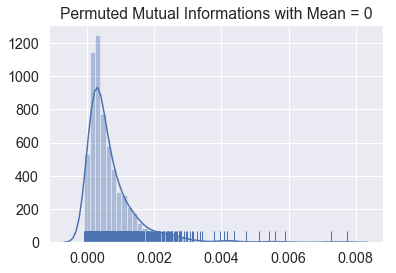

In [33]:
sns.distplot(mutual_informations, hist=True, rug=True)
plt.title("Permuted Mutual Informations with Mean = 0")
plt.show()

### Final Bit
Return the p value!

In [26]:
def rf_independence_test(X, y, n_estimators = 200, max_samples = .63, bootstrap = True, depth = 4):
    test_stat = get_mutual_information(X, y, n_estimators, max_samples, bootstrap, depth)
    null_mutual_info = permutation_test(X, y)
    p_value = sum(i >= test_stat for i in null_mutual_info)/len(null_mutual_info)
    return p_value

X, y = get_sample(1000, 0, 1)
X = np.array(X).reshape(-1, 1)
print("P-value when Mean is 0", rf_independence_test(X, y))

X, y = get_sample(1000, 1, 1)
X = np.array(X).reshape(-1, 1)
print("P-value when Mean is 1", rf_independence_test(X, y))

X, y = get_sample(1000, 5, 1)
X = np.array(X).reshape(-1, 1)
print("P-value when Mean is 1", rf_independence_test(X, y))

P-value when Mean is 0 0.421


P-value when Mean is 1 0.0


P-value when Mean is 1 0.0


## 2. Compute the cdf of H(Y) evaluated at H(Y|X; under alternative)

#### Reasoning behind this (?):
$MI_0$(X,Y) - $MI_A$(X,Y; under alt) = H(Y|X; under alt) -H(Y|X; under null) 

Under the null, $X$ and $Y$ are independent. So, this means the conditional entropy $H(Y|X)$ should equal $H(Y)$. If we can construct the distribution of $H(Y)$, our p-value is just the probability that $H(Y|X)$ is close to $H(Y)$.

### To construct distribution of H(Y)

We focus on 2 class case for now (unsure if this test will even work for more than 2 sample testing, my guess is no since mutual information involves just 2).

We know that $Y \sim Bernoulli(p)$. This is always the case since $Y$ is cateogrical and there are two classes. So $\hat p$ is a binomial. We can use our sample to estimate p. Then, for each probability of $\hat p$ which is easy with the binomial, we can contruct the entropy distribution as well by just plugging in that partiular value of $\hat p$ into the entropy equation.

### Entropy Equation for Binomial:
$H(\hat p) = \frac{1}{2}log{(2\pi ne\hat p (1 - \hat p))} + O(\frac{1}{n})$

### Code:
Note in our case, our p parameter for the binomial should just be 1/2 since we are drawing evenly from $Y = 1$ and $Y = -1$.

Note that in our code, we are also just considering the sum of y's instead of different $\hat p$'s but these are identically distributed, $\hat p$ just has a divided by n.

In [36]:
#TODO: have to change to work with other categorical data not just 1 or 0
from scipy.stats import binom
import math

def get_entropy_dist(y):
    n = len(y)
    p = y.count(1)/n
    dist = {}
    for i in range(0, n + 1):
        p_hat = i/n
        prob = binom.pmf(i, n, p)
        #NOTE: watch out here, might need to fix this line
        dist[-.5*np.log(2*math.pi*math.e*p_hat*(1 - p_hat))] = prob
    return dist

X, y = get_sample(1000, 0, 1)
X = np.array(X).reshape(-1, 1)

dist = get_entropy_dist(y)

In [37]:
keys, values = zip(*dist.items())

In [40]:
%matplotlib notebook

In [42]:
print(values)

(1.4431231913224312e-280, 5.46e-321, 3.01354e-318, 1.10802991e-315, 3.05247661923e-313, 6.720589575558e-311, 1.231813326151499e-308, 1.933298599253611e-306, 2.652307611198324e-304, 3.231162114417087e-302, 3.5391428822652406e-300, 3.520515814470391e-298, 3.2069119715201953e-296, 2.6938060560764563e-294, 2.099042034749126e-292, 1.5250092761943073e-290, 1.0376584499362639e-288, 6.638444027708746e-287, 4.006941522335615e-285, 2.288951470185322e-283, 1.2409128746641933e-281, 6.400497985116063e-280, 3.148034403729237e-278, 1.4795041323510975e-276, 6.656795237609343e-275, 2.8723721092626016e-273, 1.1905226505485812e-271, 4.746773936520518e-270, 1.8231359369328552e-268, 6.753874908289983e-267, 2.416109881663481e-265, 8.355884259688962e-264, 2.796610013163292e-262, 9.066904042684257e-261, 2.8501798822713027e-259, 8.694548735605459e-258, 2.5759507328503946e-256, 7.417858696420602e-255, 2.0777196179716044e-253, 5.664519800577651e-252, 1.5041536065182948e-250, 3.892649128039626e-249, 9.82381714155